In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  !ls

Saving BBB_labels.txt to BBB_labels.txt
Saving BBB_features.csv to BBB_features.csv
User uploaded file "BBB_labels.txt" with length 6110 bytes
BBB_features.csv  BBB_labels.txt  sample_data
User uploaded file "BBB_features.csv" with length 3357142 bytes
BBB_features.csv  BBB_labels.txt  sample_data


In [4]:
import re
import numpy as np
import pandas as pd

df = pd.read_csv('BBB_features.csv', sep=';')
label = pd.read_csv('BBB_labels.txt', header=None, sep=' ')
newdf = pd.DataFrame(columns=df.columns)
logbb = []
permeate = []
for molname in df['Objects']:
    basename = re.sub(r'_c0', '', molname)
    if basename in label[0].values:
        lobBB = label[label[0] == basename][1].values[0]
        logbb.append(lobBB)
        if lobBB > 0:
            permeate.append(1)
        else:
            permeate.append(0)
        newdf = pd.concat([newdf, df[df['Objects'] == molname]])
    else:
        print('removing', molname)

df = newdf

removing 1,1,1,2-tetrachloroethane_c1
removing 1,1,1,2-tetrachloroethane_c2

<ipython-input-4-f75cd362ee4d>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, df[df['Objects'] == molname]])



removing 1,1,1,2-tetrachloroethane_c3
removing 1,1,1,2-tetrachloroethane_c4
removing 1,1,1,2-tetrachloroethane_c5
removing 1,1,1,2-tetrachloroethane_c6
removing 1,1,1,2-tetrachloroethane_c7
removing 1,1,1,2-tetrachloroethane_c8
removing 1,4-divinyloxybutane_c10
removing 1,4-divinyloxybutane_c11
removing 1,4-divinyloxybutane_c12
removing 1,4-divinyloxybutane_c13
removing 1,4-divinyloxybutane_c14
removing 1,4-divinyloxybutane_c15
removing 1,4-divinyloxybutane_c1
removing 1,4-divinyloxybutane_c2
removing 1,4-divinyloxybutane_c3
removing 1,4-divinyloxybutane_c4
removing 1,4-divinyloxybutane_c5
removing 1,4-divinyloxybutane_c6
removing 1,4-divinyloxybutane_c7
removing 1,4-divinyloxybutane_c8
removing 1,4-divinyloxybutane_c9
removing 1-butanol_c10
removing 1-butanol_c11
removing 1-butanol_c12
removing 1-butanol_c13
removing 1-butanol_c14
removing 1-butanol_c15
removing 1-butanol_c16
removing 1-butanol_c17
removing 1-butanol_c18
removing 1-butanol_c19
removing 1-butanol_c1
removing 1-butanol

In [5]:
print('logBB', len(logbb))
print('permeate', len(permeate))
print(df.shape)

logBB 330
permeate 330
(330, 128)


In [6]:
X = df.drop(['Objects'], axis=1)
X = X.dropna(axis=1)
# remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]
# remove duplicate columns
X = X.T.drop_duplicates().T
y_regression = np.array(logbb)
y_classification = np.array(permeate)

print('X.shape', X.shape)
print('y_regression.shape', y_regression.shape)
print('y_classification.shape', y_classification.shape)

X.shape (330, 120)
y_regression.shape (330,)
y_classification.shape (330,)


In [7]:
# remove the highly correalted features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(X[to_drop], axis=1)
print('to_drop', to_drop)
print('X.shape after removing highly correlated features', X.shape)

to_drop ['S', 'G', 'W3', 'W4', 'W5', 'D2', 'D4', 'D5', 'D6', 'D7', 'D8', 'WO2', 'WO3', 'WN1', 'WN2', 'WN3', 'WN4', 'WN5', 'CW2', 'CW3', 'CW4', 'CD6', 'CD7', 'CD8', 'POL', 'MW', 'DIFF', 'HSA', 'PHSAR', 'LgD6', 'LgD7', 'LgD7.5', 'LgD8', 'LgD9', 'LgD10', '%FU5', '%FU6', '%FU7', 'LgS4', 'LgS5', 'LgS6', 'LgS7', 'LgS7.5', 'LgS8', 'LgS9', 'LgS10', 'LgS11', 'Spol/S']
X.shape after removing highly correlated features (330, 72)


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_regression_train, \
    y_regression_test, y_classification_train, \
    y_classification_test = \
    train_test_split(X, y_regression, y_classification, \
                     test_size=0.2, random_state=42)
print('X_train.shape', X_train.shape)
print('y_regression_train.shape', y_regression_train.shape)
print('y_classification_train.shape', y_classification_train.shape)
print('X_test.shape', X_test.shape)
print('y_regression_test.shape', y_regression_test.shape)
print('y_classification_test.shape', y_classification_test.shape)

ntrees = 50

X_train.shape (264, 72)
y_regression_train.shape (264,)
y_classification_train.shape (264,)
X_test.shape (66, 72)
y_regression_test.shape (66,)
y_classification_test.shape (66,)


In [9]:
import timeit

start = timeit.default_timer()
rf_regression = RandomForestRegressor(n_estimators=ntrees, random_state=42)
rf_regression.fit(X_train, y_regression_train)
y_regression_pred = rf_regression.predict(X_train)
msetrain = mean_squared_error(y_regression_train, y_regression_pred)
r2train = rf_regression.score(X_train, y_regression_train)
print('  Train R2 %5.3f'%(r2train))
print('Train MSE %8.6e'%(msetrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

  Train R2 0.947
Train MSE 2.388520e-02
Time train    0.582 s


In [10]:
msetest = mean_squared_error(y_regression_test, rf_regression.predict(X_test))
r2test = rf_regression.score(X_test, y_regression_test)
print('   Test R2 %5.3f'%(r2test))
print('  Test MSE %8.6e'%(msetest))

   Test R2 0.686
  Test MSE 1.953536e-01


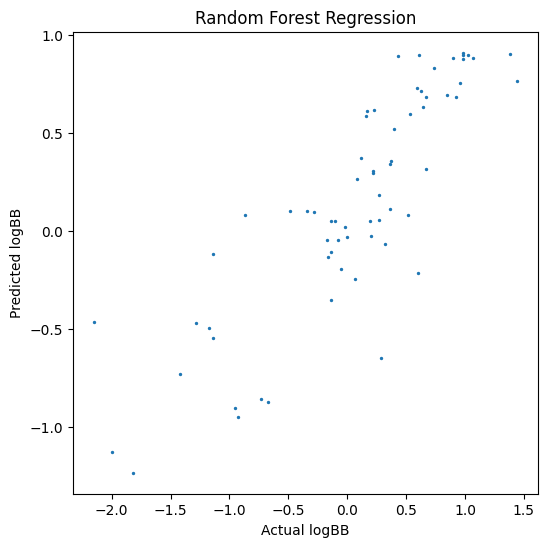

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(y_regression_test, rf_regression.predict(X_test), s=2)
#plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('Actual logBB')
plt.ylabel('Predicted logBB')
plt.title('Random Forest Regression')
plt.show()

In [12]:
# build a calssification RandomForrest model
start = timeit.default_timer()
rf_classification = RandomForestClassifier(n_estimators=ntrees, random_state=42)
rf_classification.fit(X_train, y_classification_train)
y_classification_pred = rf_classification.predict(X_train)
accuracytrain = accuracy_score(y_classification_train, y_classification_pred)
print('Train Accuracy %5.3f'%(accuracytrain))
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

Train Accuracy 1.000
Time train    0.148 s


 Test Accuracy 0.848
Confusion matrix
[[21  5]
 [ 5 35]]
Feature ranking:
 1. feature  45     PSAR 0.073590
 2. feature  43 LOGP c-Hex 0.065821
 3. feature  44      PSA 0.041723
 4. feature  42 LOGP n-Oct 0.038894
 5. feature  56    CACO2 0.036189
 6. feature  57     SKIN 0.033374
 7. feature  55       VD 0.026593
 8. feature  20      CW6 0.025276
 9. feature  39       SE 0.024102
10. feature  21      CW7 0.023264
11. feature  19      CW5 0.022784
12. feature  61       C3 0.022695
13. feature  34        A 0.021519
14. feature  65       P4 0.020399
15. feature  18      CW1 0.019541
16. feature   0        V 0.017529
17. feature  29      CD3 0.015913
18. feature  46     LgD5 0.015539
19. feature  70  FLEX_PT 0.015265
20. feature  58  MetStab 0.014569
21. feature  62       C4 0.014567
22. feature  35       CP 0.014052
23. feature  32      HL1 0.013959
24. feature  31      CD5 0.013677
25. feature  37  FLEX_RB 0.013655
26. feature  52     SOLY 0.012854
27. feature  40      SE0 0.012573
28. 

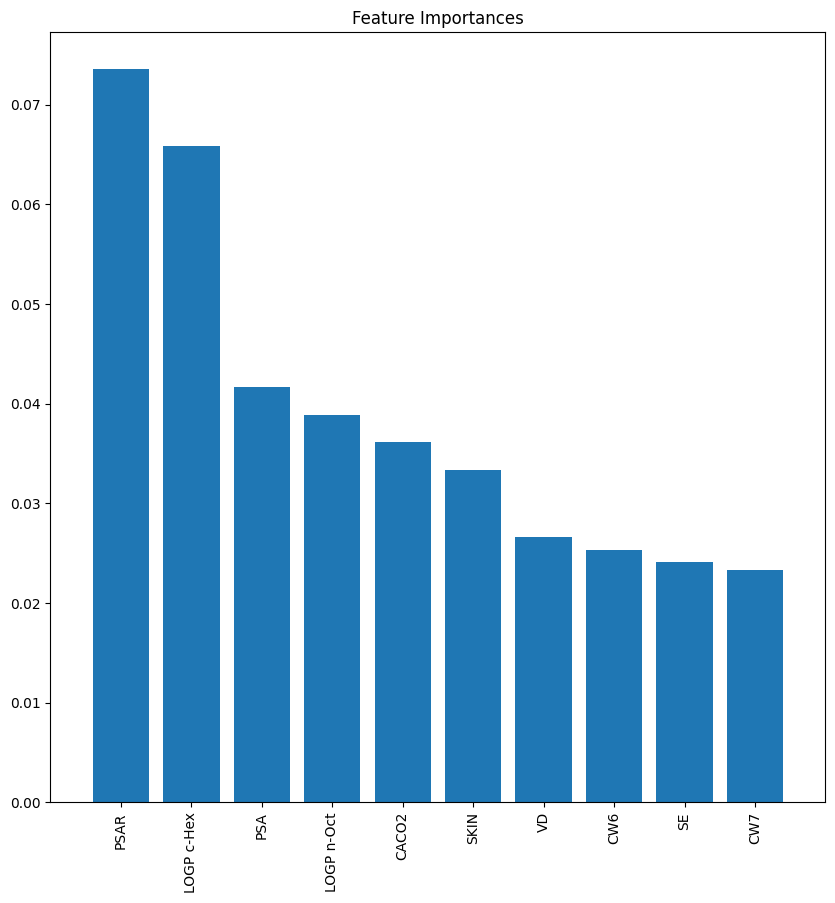

In [13]:
from sklearn.metrics import confusion_matrix

testaccuracy = accuracy_score(y_classification_test, rf_classification.predict(X_test))
print(' Test Accuracy %5.3f'%(testaccuracy))
# confusion matrix
print('Confusion matrix')
print(confusion_matrix(y_classification_test, rf_classification.predict(X_test)))
# feature importance
# Imagine each decision tree as a flowchart for making a prediction.
# The features used higher up in the flowchart (closer to the root of
# the tree) and more frequently across all flowcharts are considered
# more important because they play a bigger role in determining the outcome.
importances = rf_classification.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%2d. feature %3d %8s %f'%(f + 1, indices[f], X.columns[indices[f]], \
                                     importances[indices[f]]))
# plot feature importance of the first 10 features
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), X.columns[indices[:10]], rotation=90)
plt.xlim([-1, 10])
plt.show()
